>Link of the original dataset: https://archive.ics.uci.edu/dataset/222/bank+marketing

**Business objective:** Predict if a bank's client will sign up for a *term deposit*

- It's a **supervised learning** task and we will be using **Decision Trees**.
- The model's performance will be measured through a confusion matrix.
- The performance measure is indeed aligned with the business objective.
- The minimum acceptable performance will be recall of **85%**, but let's see about that...

In [127]:
# Basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, ShuffleSplit, StratifiedShuffleSplit, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.impute import SimpleImputer

# Models
from sklearn.tree import DecisionTreeClassifier

# Pipelines
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Metrics
from sklearn.metrics import confusion_matrix, plot_precision_recall_curve, plot_roc_curve, ConfusionMatrixDisplay, classification_report

In [2]:
df_bank = pd.read_csv("../Datasets/bank_marketing.csv")

In [3]:
df_bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


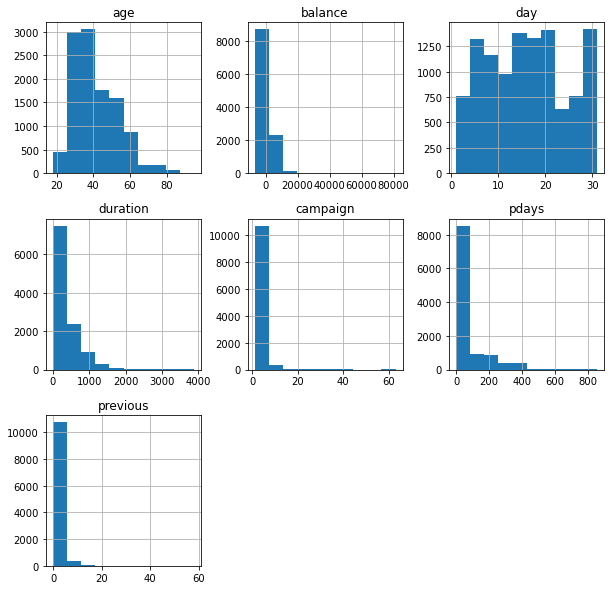

In [5]:
df_bank.hist(figsize=(10,10));

# 1) Exploring the data

In [9]:
df_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


In [10]:
df_bank.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

In [11]:
df_bank.deposit.value_counts()

no     5873
yes    5289
Name: deposit, dtype: int64

In [12]:
df_bank.shape

(11162, 17)

### Creating a training set and a test set

We'll create a **train set** and a **test set** separating them in such a way that there is the same proportion of the class to be predicted (label **deposit** in this case).

In [3]:
strat_split = StratifiedShuffleSplit(test_size=0.2, random_state=42)

In [4]:
for train_index, test_index in strat_split.split(df_bank, df_bank.deposit):
    strat_train_set = df_bank.loc[train_index]
    strat_test_set = df_bank.loc[test_index]

In [9]:
strat_train_set.shape

(8929, 17)

In [10]:
strat_test_set.shape

(2233, 17)

Since there are many features to consider, let's take a look at the correlations that all features have with respect to the label to predict.

In [20]:
pd.get_dummies(df_bank, drop_first=True).corr()["deposit_yes"].sort_values()

contact_unknown       -0.256136
poutcome_unknown      -0.230470
housing_yes           -0.203888
month_may             -0.170507
campaign              -0.128081
loan_yes              -0.110580
job_blue-collar       -0.100840
marital_married       -0.092157
day                   -0.056326
education_secondary   -0.051952
month_jul             -0.047368
job_services          -0.044531
default_yes           -0.040680
job_entrepreneur      -0.034443
month_nov             -0.028278
job_housemaid         -0.024155
month_jan             -0.021803
month_jun             -0.018982
month_aug             -0.016621
job_technician        -0.011557
job_self-employed     -0.004707
job_unknown            0.001889
education_unknown      0.014355
contact_telephone      0.016420
job_unemployed         0.033487
age                    0.034901
job_management         0.036301
poutcome_other         0.044059
month_feb              0.051710
balance                0.081129
month_dec              0.086964
educatio

Just a few attributes have a strong correlation with the label, this information will be relevant to decide the `max_features` paramater of our **machine learning model**

In [81]:
# Making a copy of the traning set so we can work safly

df_train_copy = strat_train_set.copy()

In [15]:
df_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8929 entries, 1584 to 700
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        8929 non-null   int64 
 1   job        8929 non-null   object
 2   marital    8929 non-null   object
 3   education  8929 non-null   object
 4   default    8929 non-null   object
 5   balance    8929 non-null   int64 
 6   housing    8929 non-null   object
 7   loan       8929 non-null   object
 8   contact    8929 non-null   object
 9   day        8929 non-null   int64 
 10  month      8929 non-null   object
 11  duration   8929 non-null   int64 
 12  campaign   8929 non-null   int64 
 13  pdays      8929 non-null   int64 
 14  previous   8929 non-null   int64 
 15  poutcome   8929 non-null   object
 16  deposit    8929 non-null   object
dtypes: int64(7), object(10)
memory usage: 1.2+ MB


Visualization of the **poutcome** attribute and the label **deposit**

<AxesSubplot:xlabel='poutcome', ylabel='count'>

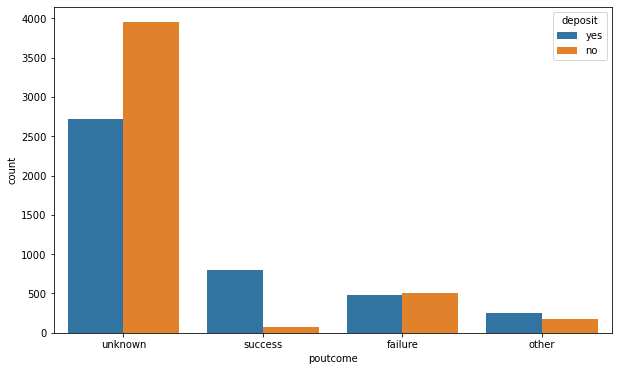

In [19]:
plt.figure(figsize=(10,6))
sns.countplot(data=df_train_copy, x="poutcome", hue="deposit")

Visualization of the **duration** attribute (correlation = 0.451919) and the label **deposit**

<AxesSubplot:xlabel='duration', ylabel='deposit'>

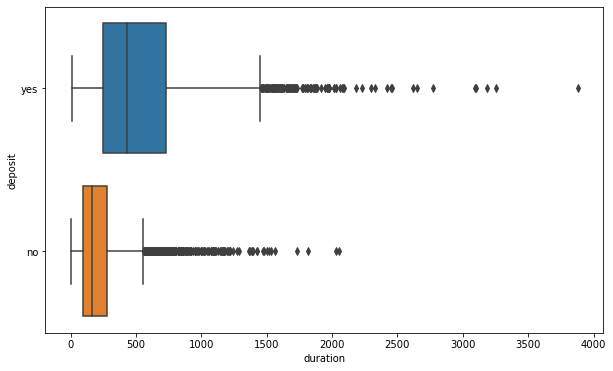

In [20]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df_train_copy, x="duration", y="deposit", orient="h")

As we can see in the graph above, apparently there are a few **outliters** in the *yes* category. Specifically instances with a **duration > 3000**.

In [23]:
df_train_copy[df_train_copy.duration > 3000]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
271,59,management,married,secondary,no,1321,no,no,unknown,9,jun,3881,3,-1,0,unknown,yes
358,28,admin.,single,secondary,no,-7,no,yes,unknown,26,jun,3183,2,-1,0,unknown,yes
153,44,services,divorced,secondary,no,51,yes,yes,unknown,27,may,3094,2,-1,0,unknown,yes
4364,53,admin.,married,secondary,no,849,yes,no,cellular,6,feb,3102,3,-1,0,unknown,yes
883,36,self-employed,single,tertiary,no,-103,yes,yes,telephone,17,oct,3253,1,-1,0,unknown,yes


Although these 5 instances definitely deviate from the "normal pattern" of all other instances, we decided to keep them for 3 reasons:
- The duration difference of these instances is not THAT big. 
- We don't want our model being unable to handle data with a slightly different pattern.
- The **duration** attribute has the strongest correlation with the label to predict (i.e. if there is an instance with high duration value is most likely that corresponds to the **yes class**) so this will help our machine learning model to predict easier. 

Visualization of the distribution of the **deposit** attribute (our label).

<AxesSubplot:xlabel='deposit', ylabel='count'>

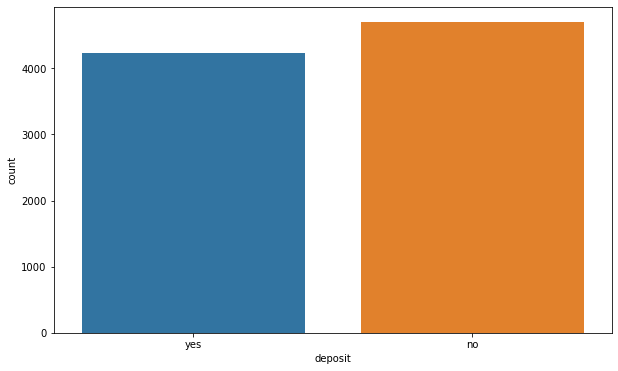

In [39]:
plt.figure(figsize=(10,6))
sns.countplot(data=df_train_copy, x="deposit")

One attribute that caught my attention from the very beginning was the **age** attribute, since by common sense, the older the person is, the more money they have (in theory). So it's most likely they will subscribe to a *term deposit* (our **business objective**).

Ironically enough, the age attribute only has a correlation of **0.034901**, that's quite low.

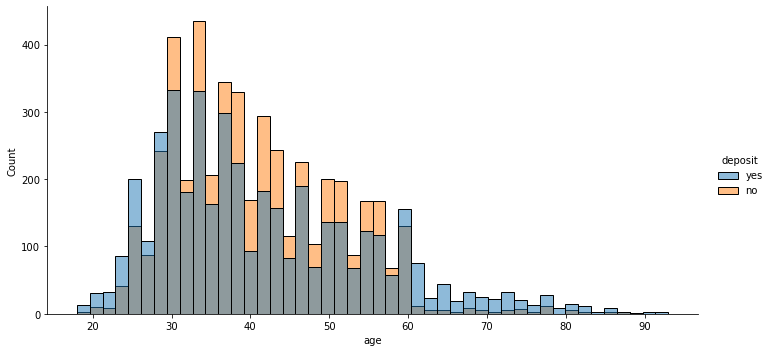

In [43]:
sns.displot(data=df_train_copy, x="age", hue="deposit",aspect=2, height=5)

<AxesSubplot:xlabel='age', ylabel='Count'>

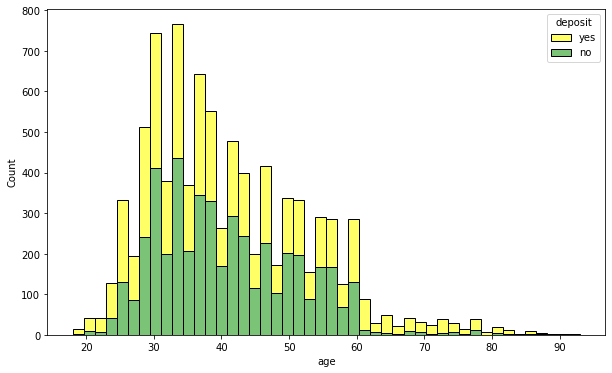

In [51]:
plt.figure(figsize=(10,6))
sns.histplot(data=df_train_copy, x="age",hue="deposit",palette="Set1_r",multiple="stack")

### Transformation 1

We decided to make a "*combination*" of the attributes **duration** and **age**. Duration indicates us how long the phone-call lasted, so according to muy thought process those two attributes may have been "attuned" well.

In [56]:
df_train_copy["duration_per_age"] = np.round(df_train_copy.duration / df_train_copy.age,2).values

In [57]:
df_train_copy

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,duration_per_age
1584,59,technician,married,secondary,no,10925,no,no,cellular,21,apr,100,1,-1,0,unknown,yes,1.69
8302,51,services,single,secondary,no,513,yes,no,cellular,29,jul,331,2,-1,0,unknown,no,6.49
3918,25,student,single,secondary,no,154,no,no,cellular,2,sep,382,1,183,3,success,yes,15.28
10141,36,admin.,single,secondary,no,810,yes,no,unknown,17,jun,296,1,-1,0,unknown,no,8.22
6373,35,blue-collar,married,secondary,no,154,yes,no,unknown,23,may,211,4,-1,0,unknown,no,6.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3606,21,student,single,unknown,no,53,no,no,cellular,14,jun,270,1,-1,0,unknown,yes,12.86
10862,42,unemployed,married,secondary,no,-165,yes,yes,unknown,27,may,179,3,-1,0,unknown,no,4.26
4833,31,management,single,secondary,no,360,yes,no,cellular,18,may,309,1,-1,0,unknown,yes,9.97
5613,57,unemployed,married,secondary,no,1350,no,no,cellular,25,jun,131,1,388,1,failure,no,2.30


### Transformation 2

We are going to apply *binary encoding* to some attributes in order to reduce the number of dummy variables that we might have.

In [59]:
df_train_copy.deposit.replace({"yes":1, "no":0},inplace=True)

In [67]:
df_train_copy.loan.replace({"yes":1, "no":0},inplace=True)

In [69]:
df_train_copy.housing.replace({"yes":1, "no":0},inplace=True)

In [70]:
df_train_copy.default.replace({"yes":1, "no":0},inplace=True)

In [71]:
df_train_copy

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,duration_per_age
1584,59,technician,married,secondary,0,10925,0,0,cellular,21,apr,100,1,-1,0,unknown,1,1.69
8302,51,services,single,secondary,0,513,1,0,cellular,29,jul,331,2,-1,0,unknown,0,6.49
3918,25,student,single,secondary,0,154,0,0,cellular,2,sep,382,1,183,3,success,1,15.28
10141,36,admin.,single,secondary,0,810,1,0,unknown,17,jun,296,1,-1,0,unknown,0,8.22
6373,35,blue-collar,married,secondary,0,154,1,0,unknown,23,may,211,4,-1,0,unknown,0,6.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3606,21,student,single,unknown,0,53,0,0,cellular,14,jun,270,1,-1,0,unknown,1,12.86
10862,42,unemployed,married,secondary,0,-165,1,1,unknown,27,may,179,3,-1,0,unknown,0,4.26
4833,31,management,single,secondary,0,360,1,0,cellular,18,may,309,1,-1,0,unknown,1,9.97
5613,57,unemployed,married,secondary,0,1350,0,0,cellular,25,jun,131,1,388,1,failure,0,2.30


In [72]:
df_train_copy.default.unique()

array([0, 1], dtype=int64)

In [73]:
df_train_copy.housing.unique()

array([0, 1], dtype=int64)

In [74]:
df_train_copy.loan.unique()

array([0, 1], dtype=int64)

### Transformation 3

Finally we'll create **dummy variables** (One hot encoding) from the categorical variables.

In [78]:
attributes_cat = df_train_copy.select_dtypes(include="object").columns
attributes_num = df_train_copy.drop("deposit",axis=1).select_dtypes(exclude="object").columns

In [82]:
categorical_set = pd.get_dummies(df_train_copy[attributes_cat],drop_first=True)

In [83]:
numerical_set = df_train_copy[attributes_num]

In [87]:
pd.concat([categorical_set,numerical_set,df_train_copy.deposit], axis=1)

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,...,balance,housing,loan,day,duration,campaign,pdays,previous,duration_per_age,deposit
1584,0,0,0,0,0,0,0,0,1,0,...,10925,0,0,21,100,1,-1,0,1.69,1
8302,0,0,0,0,0,0,1,0,0,0,...,513,1,0,29,331,2,-1,0,6.49,0
3918,0,0,0,0,0,0,0,1,0,0,...,154,0,0,2,382,1,183,3,15.28,1
10141,0,0,0,0,0,0,0,0,0,0,...,810,1,0,17,296,1,-1,0,8.22,0
6373,1,0,0,0,0,0,0,0,0,0,...,154,1,0,23,211,4,-1,0,6.03,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3606,0,0,0,0,0,0,0,1,0,0,...,53,0,0,14,270,1,-1,0,12.86,1
10862,0,0,0,0,0,0,0,0,0,1,...,-165,1,1,27,179,3,-1,0,4.26,0
4833,0,0,0,1,0,0,0,0,0,0,...,360,1,0,18,309,1,-1,0,9.97,1
5613,0,0,0,0,0,0,0,0,0,1,...,1350,0,0,25,131,1,388,1,2.30,0


Checking correlations again but now with the new transformations we made...

In [180]:
df_train_dummy = pd.concat([numerical_set,categorical_set,df_train_copy.deposit], axis=1)

In [181]:
df_train_dummy.corr()["deposit"].sort_values()

contact_unknown       -0.251418
poutcome_unknown      -0.228780
housing               -0.214810
month_may             -0.169328
campaign              -0.125152
loan                  -0.110198
job_blue-collar       -0.101400
marital_married       -0.084492
education_secondary   -0.056996
day                   -0.052529
month_jul             -0.043125
default               -0.042935
job_services          -0.042379
job_entrepreneur      -0.033231
month_nov             -0.024861
month_aug             -0.023928
job_housemaid         -0.020165
month_jun             -0.019422
month_jan             -0.017936
job_technician        -0.016511
job_self-employed     -0.006547
job_unknown            0.004235
contact_telephone      0.012542
education_unknown      0.016212
job_management         0.036182
job_unemployed         0.037123
age                    0.040726
poutcome_other         0.049774
month_feb              0.053489
balance                0.076763
month_dec              0.081035
marital_

### Surprise!!!

The new attribute we created (**duration_per_age**) has much **higher correlation** to the label than other pre-existing attributes!!

It ain't much but it's honest work  :D

# 2) Prepare the data

### Transformations to be made:

- Create a new attribute called **duration_per_age**
- Do binary encoding to the following attributes:
    - deposit
    - loan
    - housing
    - default
- Create dummy variables

**REMEMBER**: We have been working on a copy of the original data (so if something bad happens we can restore the information), now we need to apply these transformations to the dataset that we are going to feed into the machine learning model.

### Create a new attribute called *duration_per_age*

We will create a **custom transformer** to make things easy

In [136]:
attributes_num.get_loc("duration")

6

In [5]:
class DuratinoPerAge(BaseEstimator, TransformerMixin):
    def __init__(self,):
        self.duration_index = attributes_num.get_loc("duration")  # Change the name of the dataset if needed
        self.age_index = attributes_num.get_loc("age")  # Change the name of the dataset if needed
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        duration_per_age = np.round(X[:,self.duration_index].astype("float") / X[:, self.age_index].astype("float"),4)  # This caused me some troubles, but nothing I couldn't handle...
        
        df = X.copy()
        
        df = np.c_[df,duration_per_age]
        
        return df

For more information about `.astype("float")` click here: https://stackoverflow.com/questions/59297543/why-do-i-get-the-loop-of-ufunc-does-not-support-argument-0-of-type-int-error-f

In [207]:
DuratinoPerAge().fit_transform(df_train_copy.values)[0]

array([59, 'technician', 'married', 'secondary', 0, 10925, 0, 0,
       'cellular', 21, 'apr', 100, 1, -1, 0, 'unknown', 1, 1.69, 0.0],
      dtype=object)

In [212]:
df_train_copy.iloc[0]

age                         59
job                 technician
marital                married
education            secondary
default                      0
balance                  10925
housing                      0
loan                         0
contact               cellular
day                         21
month                      apr
duration                   100
campaign                     1
pdays                       -1
previous                     0
poutcome               unknown
deposit                      1
duration_per_age          1.69
Name: 1584, dtype: object

### Do binary encoding to the following attributes:
- deposit
- loan
- housing
- default

In [79]:
def binary_encoding(dataset, attributes=None):
    df = dataset.copy()
    for attribute in attributes:
        df[attribute].replace({"yes":1, "no":0}, inplace=True)
        
    return df

### Create dummy variables

This will made with `OneHotEncoder()` function

## 2.1) Creating pipelines

In [167]:
attributes_cat

Index(['job', 'marital', 'education', 'contact', 'month', 'poutcome'], dtype='object')

In [168]:
attributes_num

Index(['age', 'default', 'balance', 'housing', 'loan', 'day', 'duration',
       'campaign', 'pdays', 'previous', 'duration_per_age'],
      dtype='object')

**Numerical pipeline**

In [9]:
numerical_pipeline = Pipeline([
    ("imputer",SimpleImputer(strategy="mean")),
    ("Duration_per_age",DuratinoPerAge()),
])

**Categorical pipeline**

In [10]:
categorical_pipeline = Pipeline([
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("One_hot_encoding",OneHotEncoder(drop="first")),
])

**Full pipeline**

In [11]:
preprocessing_pipeline = ColumnTransformer([
    ("num",numerical_pipeline,attributes_num),
    ("cat",categorical_pipeline,attributes_cat),
])

Testing the pipeline

In [82]:
df_test = binary_encoding(df_train_copy, attributes=["deposit","housing","loan","default"])

preprocessing_pipeline.fit_transform(df_test[list(attributes_num)+list(attributes_cat)])[0]

array([ 5.9000e+01,  1.0925e+04,  2.1000e+01,  1.0000e+02,  1.0000e+00,
       -1.0000e+00,  0.0000e+00,  1.6949e+00,  0.0000e+00,  0.0000e+00,
        0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
        0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        0.0000e+00,  0.0000e+00,  1.0000e+00,  1.0000e+00])

In [218]:
df_train_dummy.iloc[0]

age                       59.00
default                    0.00
balance                10925.00
housing                    0.00
loan                       0.00
day                       21.00
duration                 100.00
campaign                   1.00
pdays                     -1.00
previous                   0.00
duration_per_age           1.69
job_blue-collar            0.00
job_entrepreneur           0.00
job_housemaid              0.00
job_management             0.00
job_retired                0.00
job_self-employed          0.00
job_services               0.00
job_student                0.00
job_technician             1.00
job_unemployed             0.00
job_unknown                0.00
marital_married            1.00
marital_single             0.00
education_secondary        1.00
education_tertiary         0.00
education_unknown          0.00
contact_telephone          0.00
contact_unknown            0.00
month_aug                  0.00
month_dec                  0.00
month_fe

# 3) Shortlist promissing models

In [83]:
df_final = strat_train_set.copy()

attributes_cat = df_final.select_dtypes(include="object").columns
attributes_num = df_final.select_dtypes(exclude="object").columns

In [84]:
df_final = binary_encoding(df_final, attributes=["deposit","housing","loan","default"])

X = preprocessing_pipeline.fit_transform(df_final[list(attributes_num)+list(attributes_cat)])

In [85]:
y = df_final.deposit.values

In [86]:
X.shape, y.shape

((8929, 44), (8929,))

**Training a model with default values**

In [87]:
model_decisionT_classifier = DecisionTreeClassifier(max_features=9)

In [88]:
cross_val_score(model_decisionT_classifier, X, y, cv=8)

array([1.        , 0.98566308, 0.99910394, 1.        , 0.98476703,
       0.98028674, 1.        , 1.        ])

# 4) Fine tune the system

In [19]:
help(DecisionTreeClassifier)

Help on class DecisionTreeClassifier in module sklearn.tree._classes:

class DecisionTreeClassifier(sklearn.base.ClassifierMixin, BaseDecisionTree)
 |  DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, ccp_alpha=0.0)
 |  
 |  A decision tree classifier.
 |  
 |  Read more in the :ref:`User Guide <tree>`.
 |  
 |  Parameters
 |  ----------
 |  criterion : {"gini", "entropy"}, default="gini"
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "entropy" for the information gain.
 |  
 |  splitter : {"best", "random"}, default="best"
 |      The strategy used to choose the split at each node. Supported
 |      strategies are "best" to choose the best split and "random" to choose
 |      the best ran

In [89]:
min_samples_split = [2,5,10]
min_samples_leaf = [1,5,10]
max_features = [5,9,14]
max_leaf_nodes = [5,10,15,20]

In [90]:
param_grid = {"min_samples_split":min_samples_split, "min_samples_leaf":min_samples_leaf, "max_features":max_features, "max_leaf_nodes":max_leaf_nodes}

In [91]:
model_decisionT_classifier = DecisionTreeClassifier()

In [92]:
model_grid_search = GridSearchCV(model_decisionT_classifier, param_grid, cv=8, verbose=2)

In [93]:
model_grid_search.fit(X, y)

Fitting 8 folds for each of 108 candidates, totalling 864 fits
[CV] END max_features=5, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_features=5, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_features=5, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_features=5, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_features=5, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_features=5, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_features=5, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_features=5, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_features=5, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END m

[CV] END max_features=5, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END max_features=5, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END max_features=5, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END max_features=5, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END max_features=5, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END max_features=5, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END max_features=5, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=2; total time=   0.0s
[CV] END max_features=5, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=2; total time=   0.0s
[CV] END max_features=5, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=2; total time=   0.0s
[CV] END max_features=5, max_leaf_nodes=10, min_samples_le

[CV] END max_features=5, max_leaf_nodes=15, min_samples_leaf=5, min_samples_split=2; total time=   0.0s
[CV] END max_features=5, max_leaf_nodes=15, min_samples_leaf=5, min_samples_split=2; total time=   0.0s
[CV] END max_features=5, max_leaf_nodes=15, min_samples_leaf=5, min_samples_split=2; total time=   0.0s
[CV] END max_features=5, max_leaf_nodes=15, min_samples_leaf=5, min_samples_split=2; total time=   0.0s
[CV] END max_features=5, max_leaf_nodes=15, min_samples_leaf=5, min_samples_split=2; total time=   0.0s
[CV] END max_features=5, max_leaf_nodes=15, min_samples_leaf=5, min_samples_split=2; total time=   0.0s
[CV] END max_features=5, max_leaf_nodes=15, min_samples_leaf=5, min_samples_split=5; total time=   0.0s
[CV] END max_features=5, max_leaf_nodes=15, min_samples_leaf=5, min_samples_split=5; total time=   0.0s
[CV] END max_features=5, max_leaf_nodes=15, min_samples_leaf=5, min_samples_split=5; total time=   0.0s
[CV] END max_features=5, max_leaf_nodes=15, min_samples_leaf=5, 

[CV] END max_features=5, max_leaf_nodes=20, min_samples_leaf=5, min_samples_split=5; total time=   0.0s
[CV] END max_features=5, max_leaf_nodes=20, min_samples_leaf=5, min_samples_split=5; total time=   0.0s
[CV] END max_features=5, max_leaf_nodes=20, min_samples_leaf=5, min_samples_split=5; total time=   0.0s
[CV] END max_features=5, max_leaf_nodes=20, min_samples_leaf=5, min_samples_split=10; total time=   0.0s
[CV] END max_features=5, max_leaf_nodes=20, min_samples_leaf=5, min_samples_split=10; total time=   0.0s
[CV] END max_features=5, max_leaf_nodes=20, min_samples_leaf=5, min_samples_split=10; total time=   0.0s
[CV] END max_features=5, max_leaf_nodes=20, min_samples_leaf=5, min_samples_split=10; total time=   0.0s
[CV] END max_features=5, max_leaf_nodes=20, min_samples_leaf=5, min_samples_split=10; total time=   0.0s
[CV] END max_features=5, max_leaf_nodes=20, min_samples_leaf=5, min_samples_split=10; total time=   0.0s
[CV] END max_features=5, max_leaf_nodes=20, min_samples_le

[CV] END max_features=9, max_leaf_nodes=5, min_samples_leaf=10, min_samples_split=2; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=5, min_samples_leaf=10, min_samples_split=2; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=5, min_samples_leaf=10, min_samples_split=2; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=5, min_samples_leaf=10, min_samples_split=2; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=5, min_samples_leaf=10, min_samples_split=2; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=5, min_samples_leaf=10, min_samples_split=2; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=5, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=5, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=5, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=5, min_samples_leaf=10, 

[CV] END max_features=9, max_leaf_nodes=10, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=10, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=10, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=10, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=10, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=10, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=10, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=10, min_samples_leaf=10, min_samples_split=10; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=10, min_samples_leaf=10, min_samples_split=10; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=10, min_sampl

[CV] END max_features=9, max_leaf_nodes=20, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=20, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=20, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=20, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=20, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=20, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=20, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=20, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=20, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=20, min_samples_leaf=1,

[CV] END max_features=14, max_leaf_nodes=5, min_samples_leaf=5, min_samples_split=5; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=5, min_samples_leaf=5, min_samples_split=5; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=5, min_samples_leaf=5, min_samples_split=5; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=5, min_samples_leaf=5, min_samples_split=5; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=5, min_samples_leaf=5, min_samples_split=5; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=5, min_samples_leaf=5, min_samples_split=10; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=5, min_samples_leaf=5, min_samples_split=10; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=5, min_samples_leaf=5, min_samples_split=10; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=5, min_samples_leaf=5, min_samples_split=10; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=5, min_samples_leaf

[CV] END max_features=14, max_leaf_nodes=10, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=10, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=10, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=10, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=10, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=10, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=10, min_samples_leaf=10, min_samples_split=10; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=10, min_samples_leaf=10, min_samples_split=10; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=10, min_samples_leaf=10, min_samples_split=10; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=10

[CV] END max_features=14, max_leaf_nodes=20, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=20, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=20, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=20, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=20, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=20, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=20, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=20, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=20, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=20, min_sample

GridSearchCV(cv=8, estimator=DecisionTreeClassifier(),
             param_grid={'max_features': [5, 9, 14],
                         'max_leaf_nodes': [5, 10, 15, 20],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 5, 10]},
             verbose=2)

In [94]:
model_grid_search.best_score_

0.9970878136200717

In [95]:
model_grid_search.best_params_

{'max_features': 14,
 'max_leaf_nodes': 20,
 'min_samples_leaf': 10,
 'min_samples_split': 5}

**Again with more specific values**

In [104]:
max_features = [9,10,11,12,13,14,15,16,17,18]
max_leaf_nodes = [15,20,15,30,35]
min_samples_leaf = [8,10,12,16,18,20]
min_samples_split = [4,5,6,7,8]

In [106]:
param_grid = {"max_features":max_features, "max_leaf_nodes":max_leaf_nodes, "min_samples_leaf":min_samples_leaf, "min_samples_split":min_samples_split}

model_decisionT_classifier = DecisionTreeClassifier()

model_grid_search = GridSearchCV(model_decisionT_classifier, param_grid, cv=8, verbose=2)

model_grid_search.fit(X, y)

Fitting 8 folds for each of 1500 candidates, totalling 12000 fits
[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=5; total time=   0.0

[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=4; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=4; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=5; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=5; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=5; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=5; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=5; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=5; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=5; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=15, min_samples

[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=15, min_samples

[CV] END max_features=9, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=7; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=7; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=7; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=7; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=7; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=7; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=7; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=7; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=20, min_samples_leaf=8, 

[CV] END max_features=9, max_leaf_nodes=20, min_samples_leaf=12, min_samples_split=8; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=20, min_samples_leaf=12, min_samples_split=8; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=20, min_samples_leaf=12, min_samples_split=8; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=20, min_samples_leaf=12, min_samples_split=8; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=20, min_samples_leaf=12, min_samples_split=8; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=20, min_samples_leaf=12, min_samples_split=8; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=20, min_samples_leaf=12, min_samples_split=8; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=20, min_samples_leaf=12, min_samples_split=8; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=20, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=20, min_samples

[CV] END max_features=9, max_leaf_nodes=20, min_samples_leaf=20, min_samples_split=4; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=20, min_samples_leaf=20, min_samples_split=4; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=20, min_samples_leaf=20, min_samples_split=4; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=20, min_samples_leaf=20, min_samples_split=5; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=20, min_samples_leaf=20, min_samples_split=5; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=20, min_samples_leaf=20, min_samples_split=5; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=20, min_samples_leaf=20, min_samples_split=5; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=20, min_samples_leaf=20, min_samples_split=5; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=20, min_samples_leaf=20, min_samples_split=5; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=20, min_samples

[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=7; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=7; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=7; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=15, min_samples

[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=8; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=8; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=8; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=8; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=8; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=8; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=4; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=4; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=4; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=15, min_samples

[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=8; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=8; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=8; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=8; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=8; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=8; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=30, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=30, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=30, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=30, min_samples_le

[CV] END max_features=9, max_leaf_nodes=30, min_samples_leaf=12, min_samples_split=4; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=30, min_samples_leaf=12, min_samples_split=4; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=30, min_samples_leaf=12, min_samples_split=4; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=30, min_samples_leaf=12, min_samples_split=4; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=30, min_samples_leaf=12, min_samples_split=4; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=30, min_samples_leaf=12, min_samples_split=4; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=30, min_samples_leaf=12, min_samples_split=4; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=30, min_samples_leaf=12, min_samples_split=5; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=30, min_samples_leaf=12, min_samples_split=5; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=30, min_samples

[CV] END max_features=9, max_leaf_nodes=30, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=30, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=30, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=30, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=30, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=30, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=30, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=30, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=30, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=30, min_samples

[CV] END max_features=9, max_leaf_nodes=35, min_samples_leaf=8, min_samples_split=5; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=35, min_samples_leaf=8, min_samples_split=5; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=35, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=35, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=35, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=35, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=35, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=35, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=35, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=35, min_samples_leaf=8, 

[CV] END max_features=9, max_leaf_nodes=35, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=35, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=35, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=35, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=35, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=35, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=35, min_samples_leaf=12, min_samples_split=8; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=35, min_samples_leaf=12, min_samples_split=8; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=35, min_samples_leaf=12, min_samples_split=8; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=35, min_samples

[CV] END max_features=9, max_leaf_nodes=35, min_samples_leaf=18, min_samples_split=8; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=35, min_samples_leaf=18, min_samples_split=8; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=35, min_samples_leaf=18, min_samples_split=8; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=35, min_samples_leaf=18, min_samples_split=8; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=35, min_samples_leaf=18, min_samples_split=8; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=35, min_samples_leaf=20, min_samples_split=4; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=35, min_samples_leaf=20, min_samples_split=4; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=35, min_samples_leaf=20, min_samples_split=4; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=35, min_samples_leaf=20, min_samples_split=4; total time=   0.0s
[CV] END max_features=9, max_leaf_nodes=35, min_samples

[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=4; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=4; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=4; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_sam

[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=5; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=5; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=5; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=5; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, m

[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=5; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=6; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=6; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=6; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=6; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=6; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=6; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=6; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=6; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, m

[CV] END max_features=10, max_leaf_nodes=20, min_samples_leaf=10, min_samples_split=7; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=20, min_samples_leaf=10, min_samples_split=7; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=20, min_samples_leaf=10, min_samples_split=7; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=20, min_samples_leaf=10, min_samples_split=7; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=20, min_samples_leaf=10, min_samples_split=7; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=20, min_samples_leaf=10, min_samples_split=7; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=20, min_samples_leaf=10, min_samples_split=7; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=20, min_samples_leaf=10, min_samples_split=8; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=20, min_samples_leaf=10, min_samples_split=8; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=20, m

[CV] END max_features=10, max_leaf_nodes=20, min_samples_leaf=16, min_samples_split=8; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=20, min_samples_leaf=16, min_samples_split=8; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=20, min_samples_leaf=16, min_samples_split=8; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=20, min_samples_leaf=16, min_samples_split=8; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=20, min_samples_leaf=16, min_samples_split=8; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=20, min_samples_leaf=18, min_samples_split=4; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=20, min_samples_leaf=18, min_samples_split=4; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=20, min_samples_leaf=18, min_samples_split=4; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=20, min_samples_leaf=18, min_samples_split=4; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=20, m

[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=5; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=5; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_sample

[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=6; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=6; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=6; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=6; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=6; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=6; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=6; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=6; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, m

[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=7; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=7; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=7; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=7; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=8; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=8; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=8; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=8; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=8; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=15, m

[CV] END max_features=10, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=4; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=4; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=4; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=4; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=4; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=4; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=30, m

[CV] END max_features=10, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=5; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=5; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=5; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=5; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=5; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=6; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=6; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=6; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=6; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=30, m

[CV] END max_features=10, max_leaf_nodes=30, min_samples_leaf=20, min_samples_split=7; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=30, min_samples_leaf=20, min_samples_split=7; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=30, min_samples_leaf=20, min_samples_split=7; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=30, min_samples_leaf=20, min_samples_split=7; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=30, min_samples_leaf=20, min_samples_split=7; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=30, min_samples_leaf=20, min_samples_split=7; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=30, min_samples_leaf=20, min_samples_split=7; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=30, min_samples_leaf=20, min_samples_split=8; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=30, min_samples_leaf=20, min_samples_split=8; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=30, m

[CV] END max_features=10, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=8; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=8; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=8; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=8; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=35, min_samples_leaf=12, min_samples_split=4; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=35, min_samples_leaf=12, min_samples_split=4; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=35, min_samples_leaf=12, min_samples_split=4; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=35, min_samples_leaf=12, min_samples_split=4; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=35, min_samples_leaf=12, min_samples_split=4; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=35, m

[CV] END max_features=10, max_leaf_nodes=35, min_samples_leaf=18, min_samples_split=4; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=35, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=35, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=35, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=35, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=35, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=35, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=35, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=35, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_features=10, max_leaf_nodes=35, m

[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=7; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=7; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=7; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=7; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, min_sample

[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=8; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=8; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=8; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, m

[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=4; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=4; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=4; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=4; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=4; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=4; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=4; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=4; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=5; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, m

[CV] END max_features=11, max_leaf_nodes=20, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=20, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=20, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=20, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=20, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=20, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=20, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=20, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=20, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=20, m

[CV] END max_features=11, max_leaf_nodes=20, min_samples_leaf=16, min_samples_split=7; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=20, min_samples_leaf=16, min_samples_split=7; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=20, min_samples_leaf=16, min_samples_split=7; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=20, min_samples_leaf=16, min_samples_split=7; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=20, min_samples_leaf=16, min_samples_split=7; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=20, min_samples_leaf=16, min_samples_split=7; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=20, min_samples_leaf=16, min_samples_split=7; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=20, min_samples_leaf=16, min_samples_split=8; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=20, min_samples_leaf=16, min_samples_split=8; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=20, m

[CV] END max_features=11, max_leaf_nodes=20, min_samples_leaf=20, min_samples_split=8; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=20, min_samples_leaf=20, min_samples_split=8; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=20, min_samples_leaf=20, min_samples_split=8; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, min_sam

[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=5; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=5; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=5; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=5; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=5; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=5; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=5; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=6; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=6; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, m

[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=7; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=7; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=15, m

[CV] END max_features=11, max_leaf_nodes=30, min_samples_leaf=8, min_samples_split=7; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=30, min_samples_leaf=8, min_samples_split=7; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=30, min_samples_leaf=8, min_samples_split=7; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=30, min_samples_leaf=8, min_samples_split=7; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=30, min_samples_leaf=8, min_samples_split=7; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=30, min_samples_leaf=8, min_samples_split=7; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=30, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=30, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=30, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=30, min_sample

[CV] END max_features=11, max_leaf_nodes=30, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=30, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=30, min_samples_leaf=12, min_samples_split=8; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=30, min_samples_leaf=12, min_samples_split=8; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=30, min_samples_leaf=12, min_samples_split=8; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=30, min_samples_leaf=12, min_samples_split=8; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=30, min_samples_leaf=12, min_samples_split=8; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=30, min_samples_leaf=12, min_samples_split=8; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=30, min_samples_leaf=12, min_samples_split=8; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=30, m

[CV] END max_features=11, max_leaf_nodes=30, min_samples_leaf=18, min_samples_split=8; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=30, min_samples_leaf=18, min_samples_split=8; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=30, min_samples_leaf=18, min_samples_split=8; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=30, min_samples_leaf=18, min_samples_split=8; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=30, min_samples_leaf=18, min_samples_split=8; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=30, min_samples_leaf=18, min_samples_split=8; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=30, min_samples_leaf=20, min_samples_split=4; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=30, min_samples_leaf=20, min_samples_split=4; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=30, min_samples_leaf=20, min_samples_split=4; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=30, m

[CV] END max_features=11, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=4; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=4; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=4; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=4; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=4; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=4; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=35, m

[CV] END max_features=11, max_leaf_nodes=35, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=35, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=35, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=35, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=35, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=35, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=35, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=35, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=35, min_samples_leaf=16, min_samples_split=5; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=35, m

[CV] END max_features=11, max_leaf_nodes=35, min_samples_leaf=20, min_samples_split=4; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=35, min_samples_leaf=20, min_samples_split=4; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=35, min_samples_leaf=20, min_samples_split=4; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=35, min_samples_leaf=20, min_samples_split=4; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=35, min_samples_leaf=20, min_samples_split=4; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=35, min_samples_leaf=20, min_samples_split=5; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=35, min_samples_leaf=20, min_samples_split=5; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=35, min_samples_leaf=20, min_samples_split=5; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=35, min_samples_leaf=20, min_samples_split=5; total time=   0.0s
[CV] END max_features=11, max_leaf_nodes=35, m

[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, m

[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=7; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=7; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=7; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=7; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=7; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=7; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=7; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=7; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=8; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, m

[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=7; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=7; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=7; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=7; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=7; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=8; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=8; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=8; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=8; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, m

[CV] END max_features=12, max_leaf_nodes=20, min_samples_leaf=10, min_samples_split=8; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=20, min_samples_leaf=10, min_samples_split=8; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=20, min_samples_leaf=10, min_samples_split=8; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=20, min_samples_leaf=10, min_samples_split=8; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=20, min_samples_leaf=12, min_samples_split=4; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=20, min_samples_leaf=12, min_samples_split=4; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=20, min_samples_leaf=12, min_samples_split=4; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=20, min_samples_leaf=12, min_samples_split=4; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=20, min_samples_leaf=12, min_samples_split=4; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=20, m

[CV] END max_features=12, max_leaf_nodes=20, min_samples_leaf=18, min_samples_split=4; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=20, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=20, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=20, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=20, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=20, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=20, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=20, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=20, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=20, m

[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=5; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, min_sample

[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=8; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=8; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=8; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, m

[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=7; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=7; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=7; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=7; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=7; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=7; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=7; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=7; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=8; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=15, m

[CV] END max_features=12, max_leaf_nodes=30, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=30, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=30, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=30, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=30, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=30, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=30, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=30, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=4; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=30, min_sampl

[CV] END max_features=12, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=5; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=30, m

[CV] END max_features=12, max_leaf_nodes=30, min_samples_leaf=20, min_samples_split=4; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=30, min_samples_leaf=20, min_samples_split=5; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=30, min_samples_leaf=20, min_samples_split=5; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=30, min_samples_leaf=20, min_samples_split=5; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=30, min_samples_leaf=20, min_samples_split=5; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=30, min_samples_leaf=20, min_samples_split=5; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=30, min_samples_leaf=20, min_samples_split=5; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=30, min_samples_leaf=20, min_samples_split=5; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=30, min_samples_leaf=20, min_samples_split=5; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=30, m

[CV] END max_features=12, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=7; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=7; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=7; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=7; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=7; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=7; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=35, m

[CV] END max_features=12, max_leaf_nodes=35, min_samples_leaf=16, min_samples_split=7; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=35, min_samples_leaf=16, min_samples_split=7; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=35, min_samples_leaf=16, min_samples_split=7; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=35, min_samples_leaf=16, min_samples_split=7; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=35, min_samples_leaf=16, min_samples_split=7; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=35, min_samples_leaf=16, min_samples_split=7; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=35, min_samples_leaf=16, min_samples_split=8; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=35, min_samples_leaf=16, min_samples_split=8; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=35, min_samples_leaf=16, min_samples_split=8; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=35, m

[CV] END max_features=12, max_leaf_nodes=35, min_samples_leaf=20, min_samples_split=7; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=35, min_samples_leaf=20, min_samples_split=8; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=35, min_samples_leaf=20, min_samples_split=8; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=35, min_samples_leaf=20, min_samples_split=8; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=35, min_samples_leaf=20, min_samples_split=8; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=35, min_samples_leaf=20, min_samples_split=8; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=35, min_samples_leaf=20, min_samples_split=8; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=35, min_samples_leaf=20, min_samples_split=8; total time=   0.0s
[CV] END max_features=12, max_leaf_nodes=35, min_samples_leaf=20, min_samples_split=8; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=15, m

[CV] END max_features=13, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=8; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=4; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=4; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=4; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=4; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=4; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=4; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=4; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=4; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=15, m

[CV] END max_features=13, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=15, m

[CV] END max_features=13, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=5; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=5; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=20, min_sample

[CV] END max_features=13, max_leaf_nodes=20, min_samples_leaf=12, min_samples_split=6; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=20, min_samples_leaf=12, min_samples_split=6; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=20, min_samples_leaf=12, min_samples_split=6; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=20, min_samples_leaf=12, min_samples_split=6; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=20, min_samples_leaf=12, min_samples_split=6; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=20, min_samples_leaf=12, min_samples_split=6; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=20, min_samples_leaf=12, min_samples_split=6; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=20, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=20, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=20, m

[CV] END max_features=13, max_leaf_nodes=20, min_samples_leaf=18, min_samples_split=7; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=20, min_samples_leaf=18, min_samples_split=7; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=20, min_samples_leaf=18, min_samples_split=7; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=20, min_samples_leaf=18, min_samples_split=8; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=20, min_samples_leaf=18, min_samples_split=8; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=20, min_samples_leaf=18, min_samples_split=8; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=20, min_samples_leaf=18, min_samples_split=8; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=20, min_samples_leaf=18, min_samples_split=8; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=20, min_samples_leaf=18, min_samples_split=8; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=20, m

[CV] END max_features=13, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=4; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=4; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=4; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=4; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=4; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=4; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=15, min_

[CV] END max_features=13, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=5; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=5; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=5; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=5; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=5; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=5; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=5; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=6; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=6; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=15, m

[CV] END max_features=13, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=5; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=5; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=5; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=6; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=6; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=6; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=6; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=6; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=6; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=15, m

[CV] END max_features=13, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=30, m

[CV] END max_features=13, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=5; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=5; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=5; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=5; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=6; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=6; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=6; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=6; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=6; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=30, m

[CV] END max_features=13, max_leaf_nodes=30, min_samples_leaf=20, min_samples_split=6; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=30, min_samples_leaf=20, min_samples_split=7; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=30, min_samples_leaf=20, min_samples_split=7; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=30, min_samples_leaf=20, min_samples_split=7; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=30, min_samples_leaf=20, min_samples_split=7; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=30, min_samples_leaf=20, min_samples_split=7; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=30, min_samples_leaf=20, min_samples_split=7; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=30, min_samples_leaf=20, min_samples_split=7; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=30, min_samples_leaf=20, min_samples_split=7; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=30, m

[CV] END max_features=13, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=7; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=7; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=7; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=7; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=7; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=7; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=7; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=35, m

[CV] END max_features=13, max_leaf_nodes=35, min_samples_leaf=16, min_samples_split=8; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=35, min_samples_leaf=16, min_samples_split=8; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=35, min_samples_leaf=16, min_samples_split=8; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=35, min_samples_leaf=16, min_samples_split=8; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=35, min_samples_leaf=16, min_samples_split=8; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=35, min_samples_leaf=16, min_samples_split=8; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=35, min_samples_leaf=18, min_samples_split=4; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=35, min_samples_leaf=18, min_samples_split=4; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=35, min_samples_leaf=18, min_samples_split=4; total time=   0.0s
[CV] END max_features=13, max_leaf_nodes=35, m

[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=5; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=5; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=5; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, min_sample

[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=5; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=5; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=6; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=6; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=6; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=6; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=6; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=6; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=6; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, m

[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=7; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=7; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=7; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=7; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=7; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=7; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=7; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=7; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, m

[CV] END max_features=14, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=7; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=7; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=7; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=20, min_sample

[CV] END max_features=14, max_leaf_nodes=20, min_samples_leaf=12, min_samples_split=8; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=20, min_samples_leaf=12, min_samples_split=8; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=20, min_samples_leaf=12, min_samples_split=8; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=20, min_samples_leaf=12, min_samples_split=8; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=20, min_samples_leaf=12, min_samples_split=8; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=20, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=20, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=20, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=20, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=20, m

[CV] END max_features=14, max_leaf_nodes=20, min_samples_leaf=20, min_samples_split=4; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=20, min_samples_leaf=20, min_samples_split=4; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=20, min_samples_leaf=20, min_samples_split=4; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=20, min_samples_leaf=20, min_samples_split=4; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=20, min_samples_leaf=20, min_samples_split=4; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=20, min_samples_leaf=20, min_samples_split=5; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=20, min_samples_leaf=20, min_samples_split=5; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=20, min_samples_leaf=20, min_samples_split=5; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=20, min_samples_leaf=20, min_samples_split=5; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=20, m

[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, m

[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=6; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=6; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=6; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=6; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=6; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=7; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=7; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=7; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=7; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, m

[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=7; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=7; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=7; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=8; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=8; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=8; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=8; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=8; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=8; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=15, m

[CV] END max_features=14, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=8; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=30, min_samples_leaf=12, min_samples_split=4; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=30, min_samples_leaf=12, min_samples_split=4; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=30, min_samples_leaf=12, min_samples_split=4; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=30, min_samples_leaf=12, min_samples_split=4; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=30, min_samples_leaf=12, min_samples_split=4; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=30, min_samples_leaf=12, min_samples_split=4; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=30, min_samples_leaf=12, min_samples_split=4; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=30, min_samples_leaf=12, min_samples_split=4; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=30, m

[CV] END max_features=14, max_leaf_nodes=30, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=30, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=30, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=30, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=30, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=30, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=30, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=30, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=30, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=30, m

[CV] END max_features=14, max_leaf_nodes=35, min_samples_leaf=8, min_samples_split=5; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=35, min_samples_leaf=8, min_samples_split=5; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=35, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=35, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=35, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=35, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=35, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=35, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=35, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=35, min_sample

[CV] END max_features=14, max_leaf_nodes=35, min_samples_leaf=12, min_samples_split=6; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=35, min_samples_leaf=12, min_samples_split=6; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=35, min_samples_leaf=12, min_samples_split=6; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=35, min_samples_leaf=12, min_samples_split=6; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=35, min_samples_leaf=12, min_samples_split=6; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=35, min_samples_leaf=12, min_samples_split=6; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=35, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=35, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=35, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=35, m

[CV] END max_features=14, max_leaf_nodes=35, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=35, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=35, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=35, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=35, min_samples_leaf=18, min_samples_split=7; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=35, min_samples_leaf=18, min_samples_split=7; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=35, min_samples_leaf=18, min_samples_split=7; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=35, min_samples_leaf=18, min_samples_split=7; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=35, min_samples_leaf=18, min_samples_split=7; total time=   0.0s
[CV] END max_features=14, max_leaf_nodes=35, m

[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=7; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=7; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=7; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, min_sample

[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=8; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=8; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=8; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=8; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, m

[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=8; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=8; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=8; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=8; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=4; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=4; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=4; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=4; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=4; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, m

[CV] END max_features=15, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=20, min_samples_leaf=10, min_samples_split=4; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=20, min_samples_leaf=10, min_samples_split=4; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=20, min_samples_leaf=10, min_samples_split=4; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=20, min_samples_leaf=10, min_samples_split=4; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=20, min_samples_leaf=10, min_samples_split=4; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=20, min_samples_leaf=10, min_samples_split=4; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=20, min_

[CV] END max_features=15, max_leaf_nodes=20, min_samples_leaf=12, min_samples_split=8; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=20, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=20, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=20, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=20, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=20, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=20, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=20, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=20, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=20, m

[CV] END max_features=15, max_leaf_nodes=20, min_samples_leaf=20, min_samples_split=4; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=20, min_samples_leaf=20, min_samples_split=4; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=20, min_samples_leaf=20, min_samples_split=4; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=20, min_samples_leaf=20, min_samples_split=4; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=20, min_samples_leaf=20, min_samples_split=4; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=20, min_samples_leaf=20, min_samples_split=5; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=20, min_samples_leaf=20, min_samples_split=5; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=20, min_samples_leaf=20, min_samples_split=5; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=20, min_samples_leaf=20, min_samples_split=5; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=20, m

[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, m

[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=5; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=5; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=5; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=5; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=6; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=6; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=6; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=6; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=6; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, m

[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=6; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=6; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=6; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=7; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=7; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=7; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=7; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=7; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=7; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=15, m

[CV] END max_features=15, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=7; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=7; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=7; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=7; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=7; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=7; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=8; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=8; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=8; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=30, m

[CV] END max_features=15, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=8; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=8; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=8; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=8; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=8; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=8; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=30, min_samples_leaf=18, min_samples_split=4; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=30, min_samples_leaf=18, min_samples_split=4; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=30, min_samples_leaf=18, min_samples_split=4; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=30, m

[CV] END max_features=15, max_leaf_nodes=35, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=35, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=35, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=35, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=35, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=35, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=35, min_samples_leaf=8, min_samples_split=5; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=35, min_samples_leaf=8, min_samples_split=5; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=35, min_samples_leaf=8, min_samples_split=5; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=35, min_sample

[CV] END max_features=15, max_leaf_nodes=35, min_samples_leaf=12, min_samples_split=4; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=35, min_samples_leaf=12, min_samples_split=5; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=35, min_samples_leaf=12, min_samples_split=5; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=35, min_samples_leaf=12, min_samples_split=5; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=35, min_samples_leaf=12, min_samples_split=5; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=35, min_samples_leaf=12, min_samples_split=5; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=35, min_samples_leaf=12, min_samples_split=5; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=35, min_samples_leaf=12, min_samples_split=5; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=35, min_samples_leaf=12, min_samples_split=5; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=35, m

[CV] END max_features=15, max_leaf_nodes=35, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=35, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=35, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=35, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=35, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=35, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=35, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=35, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=35, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=15, max_leaf_nodes=35, m

[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=7; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=7; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=7; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=7; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, min_sample

[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=8; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=8; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, m

[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=8; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=8; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=8; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=8; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=8; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=8; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=8; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=8; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=4; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, m

[CV] END max_features=16, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=20, min_samples_leaf=10, min_samples_split=4; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=20, min_samples_leaf=10, min_samples_split=4; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=20, min_samples_leaf=10, min_samples_split=4; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=20, min_samples_leaf=10, min_samples_split=4; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=20, min_sa

[CV] END max_features=16, max_leaf_nodes=20, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=20, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=20, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=20, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=20, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=20, min_samples_leaf=16, min_samples_split=5; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=20, min_samples_leaf=16, min_samples_split=5; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=20, min_samples_leaf=16, min_samples_split=5; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=20, min_samples_leaf=16, min_samples_split=5; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=20, m

[CV] END max_features=16, max_leaf_nodes=20, min_samples_leaf=20, min_samples_split=6; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=20, min_samples_leaf=20, min_samples_split=6; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=20, min_samples_leaf=20, min_samples_split=6; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=20, min_samples_leaf=20, min_samples_split=6; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=20, min_samples_leaf=20, min_samples_split=6; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=20, min_samples_leaf=20, min_samples_split=6; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=20, min_samples_leaf=20, min_samples_split=7; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=20, min_samples_leaf=20, min_samples_split=7; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=20, min_samples_leaf=20, min_samples_split=7; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=20, m

[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=7; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=7; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=7; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=7; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=7; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=7; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=7; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=7; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=8; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, m

[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=7; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=8; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=8; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=8; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=8; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=8; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=8; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=8; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=8; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, m

[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=8; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=8; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=8; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=8; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=8; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=8; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=8; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=8; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=30, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=30, mi

[CV] END max_features=16, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=8; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=8; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=8; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=8; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=8; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=8; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=30, min_samples_leaf=12, min_samples_split=4; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=30, min_samples_leaf=12, min_samples_split=4; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=30, min_samples_leaf=12, min_samples_split=4; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=30, m

[CV] END max_features=16, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=8; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=8; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=30, min_samples_leaf=18, min_samples_split=4; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=30, min_samples_leaf=18, min_samples_split=4; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=30, min_samples_leaf=18, min_samples_split=4; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=30, min_samples_leaf=18, min_samples_split=4; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=30, min_samples_leaf=18, min_samples_split=4; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=30, min_samples_leaf=18, min_samples_split=4; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=30, min_samples_leaf=18, min_samples_split=4; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=30, m

[CV] END max_features=16, max_leaf_nodes=35, min_samples_leaf=8, min_samples_split=5; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=35, min_samples_leaf=8, min_samples_split=5; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=35, min_samples_leaf=8, min_samples_split=5; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=35, min_samples_leaf=8, min_samples_split=5; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=35, min_samples_leaf=8, min_samples_split=5; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=35, min_samples_leaf=8, min_samples_split=5; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=35, min_samples_leaf=8, min_samples_split=5; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=35, min_samples_leaf=8, min_samples_split=5; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=35, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=35, min_sample

[CV] END max_features=16, max_leaf_nodes=35, min_samples_leaf=12, min_samples_split=5; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=35, min_samples_leaf=12, min_samples_split=5; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=35, min_samples_leaf=12, min_samples_split=5; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=35, min_samples_leaf=12, min_samples_split=5; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=35, min_samples_leaf=12, min_samples_split=5; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=35, min_samples_leaf=12, min_samples_split=6; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=35, min_samples_leaf=12, min_samples_split=6; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=35, min_samples_leaf=12, min_samples_split=6; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=35, min_samples_leaf=12, min_samples_split=6; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=35, m

[CV] END max_features=16, max_leaf_nodes=35, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=35, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=35, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=35, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=35, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=35, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=35, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=35, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=35, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=16, max_leaf_nodes=35, m

[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=7; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=7; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=7; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_sample

[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, m

[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=7; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, m

[CV] END max_features=17, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=7; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=7; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=20, min_sample

[CV] END max_features=17, max_leaf_nodes=20, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=20, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=20, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=20, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=20, min_samples_leaf=12, min_samples_split=8; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=20, min_samples_leaf=12, min_samples_split=8; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=20, min_samples_leaf=12, min_samples_split=8; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=20, min_samples_leaf=12, min_samples_split=8; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=20, min_samples_leaf=12, min_samples_split=8; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=20, m

[CV] END max_features=17, max_leaf_nodes=20, min_samples_leaf=18, min_samples_split=8; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=20, min_samples_leaf=18, min_samples_split=8; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=20, min_samples_leaf=18, min_samples_split=8; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=20, min_samples_leaf=18, min_samples_split=8; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=20, min_samples_leaf=18, min_samples_split=8; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=20, min_samples_leaf=18, min_samples_split=8; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=20, min_samples_leaf=18, min_samples_split=8; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=20, min_samples_leaf=20, min_samples_split=4; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=20, min_samples_leaf=20, min_samples_split=4; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=20, m

[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=4; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=4; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=4; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=4; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=4; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=4; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_

[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=5; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=5; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=5; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=5; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=5; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, m

[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=5; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=5; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=5; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=5; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=5; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=15, m

[CV] END max_features=17, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=7; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=7; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=30, m

[CV] END max_features=17, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=7; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=7; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=30, m

[CV] END max_features=17, max_leaf_nodes=30, min_samples_leaf=20, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=30, min_samples_leaf=20, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=30, min_samples_leaf=20, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=30, min_samples_leaf=20, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=30, min_samples_leaf=20, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=30, min_samples_leaf=20, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=30, min_samples_leaf=20, min_samples_split=7; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=30, min_samples_leaf=20, min_samples_split=7; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=30, min_samples_leaf=20, min_samples_split=7; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=30, m

[CV] END max_features=17, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=7; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=7; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=35, m

[CV] END max_features=17, max_leaf_nodes=35, min_samples_leaf=16, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=35, min_samples_leaf=16, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=35, min_samples_leaf=16, min_samples_split=6; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=35, min_samples_leaf=16, min_samples_split=7; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=35, min_samples_leaf=16, min_samples_split=7; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=35, min_samples_leaf=16, min_samples_split=7; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=35, min_samples_leaf=16, min_samples_split=7; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=35, min_samples_leaf=16, min_samples_split=7; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=35, min_samples_leaf=16, min_samples_split=7; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=35, m

[CV] END max_features=17, max_leaf_nodes=35, min_samples_leaf=20, min_samples_split=7; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=35, min_samples_leaf=20, min_samples_split=7; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=35, min_samples_leaf=20, min_samples_split=7; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=35, min_samples_leaf=20, min_samples_split=7; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=35, min_samples_leaf=20, min_samples_split=8; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=35, min_samples_leaf=20, min_samples_split=8; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=35, min_samples_leaf=20, min_samples_split=8; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=35, min_samples_leaf=20, min_samples_split=8; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=35, min_samples_leaf=20, min_samples_split=8; total time=   0.0s
[CV] END max_features=17, max_leaf_nodes=35, m

[CV] END max_features=18, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=7; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=7; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=7; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=7; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=8; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=8; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=8; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=8; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=15, min_samples_leaf=10, min_samples_split=8; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=15, m

[CV] END max_features=18, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=8; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=8; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=8; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=8; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=8; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=15, min_samples_leaf=16, min_samples_split=8; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=4; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=4; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=4; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=15, m

[CV] END max_features=18, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=5; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=5; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=5; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=5; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=20, min_samples_leaf=8, min_samples_split=5; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=20, min_sample

[CV] END max_features=18, max_leaf_nodes=20, min_samples_leaf=12, min_samples_split=5; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=20, min_samples_leaf=12, min_samples_split=5; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=20, min_samples_leaf=12, min_samples_split=5; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=20, min_samples_leaf=12, min_samples_split=5; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=20, min_samples_leaf=12, min_samples_split=5; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=20, min_samples_leaf=12, min_samples_split=5; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=20, min_samples_leaf=12, min_samples_split=6; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=20, min_samples_leaf=12, min_samples_split=6; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=20, min_samples_leaf=12, min_samples_split=6; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=20, m

[CV] END max_features=18, max_leaf_nodes=20, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=20, min_samples_leaf=18, min_samples_split=5; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=20, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=20, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=20, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=20, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=20, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=20, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=20, min_samples_leaf=18, min_samples_split=6; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=20, m

[CV] END max_features=18, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=7; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=7; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=7; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=15, min_samples_leaf=8, min_samples_split=7; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=15, min_sample

[CV] END max_features=18, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=7; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=8; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=15, min_samples_leaf=12, min_samples_split=8; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=15, m

[CV] END max_features=18, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=8; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=8; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=8; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=8; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=8; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=8; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=4; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=4; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=15, min_samples_leaf=20, min_samples_split=4; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=15, m

[CV] END max_features=18, max_leaf_nodes=30, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=30, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=30, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=30, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=4; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=4; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=4; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=4; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=4; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=30, min_s

[CV] END max_features=18, max_leaf_nodes=30, min_samples_leaf=12, min_samples_split=8; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=30, min_samples_leaf=16, min_samples_split=4; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=30, m

[CV] END max_features=18, max_leaf_nodes=30, min_samples_leaf=20, min_samples_split=4; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=30, min_samples_leaf=20, min_samples_split=5; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=30, min_samples_leaf=20, min_samples_split=5; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=30, min_samples_leaf=20, min_samples_split=5; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=30, min_samples_leaf=20, min_samples_split=5; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=30, min_samples_leaf=20, min_samples_split=5; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=30, min_samples_leaf=20, min_samples_split=5; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=30, min_samples_leaf=20, min_samples_split=5; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=30, min_samples_leaf=20, min_samples_split=5; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=30, m

[CV] END max_features=18, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=35, min_samples_leaf=10, min_samples_split=6; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=35, m

[CV] END max_features=18, max_leaf_nodes=35, min_samples_leaf=16, min_samples_split=5; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=35, min_samples_leaf=16, min_samples_split=5; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=35, min_samples_leaf=16, min_samples_split=5; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=35, min_samples_leaf=16, min_samples_split=6; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=35, min_samples_leaf=16, min_samples_split=6; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=35, min_samples_leaf=16, min_samples_split=6; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=35, min_samples_leaf=16, min_samples_split=6; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=35, min_samples_leaf=16, min_samples_split=6; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=35, min_samples_leaf=16, min_samples_split=6; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=35, m

[CV] END max_features=18, max_leaf_nodes=35, min_samples_leaf=20, min_samples_split=6; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=35, min_samples_leaf=20, min_samples_split=6; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=35, min_samples_leaf=20, min_samples_split=6; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=35, min_samples_leaf=20, min_samples_split=6; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=35, min_samples_leaf=20, min_samples_split=6; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=35, min_samples_leaf=20, min_samples_split=6; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=35, min_samples_leaf=20, min_samples_split=6; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=35, min_samples_leaf=20, min_samples_split=6; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=35, min_samples_leaf=20, min_samples_split=7; total time=   0.0s
[CV] END max_features=18, max_leaf_nodes=35, m

GridSearchCV(cv=8, estimator=DecisionTreeClassifier(),
             param_grid={'max_features': [9, 10, 11, 12, 13, 14, 15, 16, 17,
                                          18],
                         'max_leaf_nodes': [15, 20, 15, 30, 35],
                         'min_samples_leaf': [8, 10, 12, 16, 18, 20],
                         'min_samples_split': [4, 5, 6, 7, 8]},
             verbose=2)

In [107]:
model_grid_search.best_score_

1.0

In [108]:
model_grid_search.best_params_

{'max_features': 14,
 'max_leaf_nodes': 15,
 'min_samples_leaf': 8,
 'min_samples_split': 7}

In [109]:
cross_val_score(model_grid_search.best_estimator_, X, y, cv=8)

array([0.95881826, 1.        , 0.84050179, 0.92741935, 0.99462366,
       1.        , 0.98297491, 1.        ])

Making predictions on the test model

In [110]:
y_train_pred = model_grid_search.predict(X)

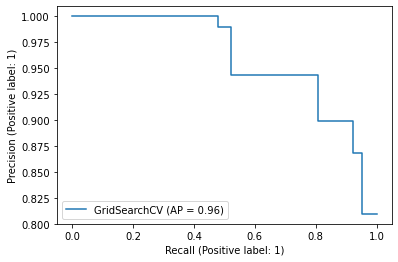

In [111]:
plot_precision_recall_curve(model_grid_search, X, y)

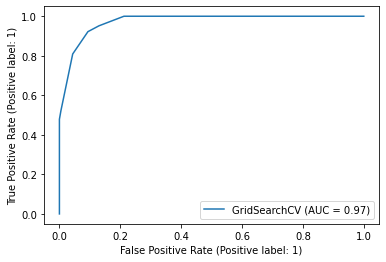

In [112]:
plot_roc_curve(model_grid_search, X, y)

Our *Area under the Curve* (AUC) is not bad at all.

# 5) Final Decision Tree model

In [113]:
model_decisionT_classifier = DecisionTreeClassifier(max_features=14, max_leaf_nodes=15)

In [114]:
model_decisionT_classifier.fit(X, y)

DecisionTreeClassifier(max_features=14, max_leaf_nodes=15)

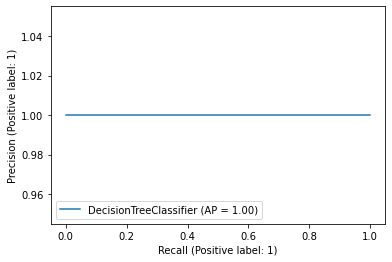

In [115]:
plot_precision_recall_curve(model_decisionT_classifier, X, y)

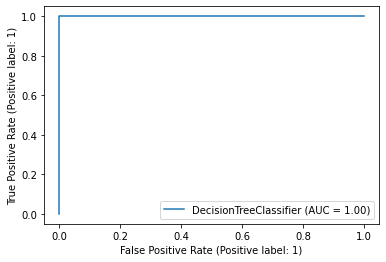

In [116]:
plot_roc_curve(model_decisionT_classifier, X, y)

In [117]:
y_train_pred = model_decisionT_classifier.predict(X)

In [118]:
conf_matrix = confusion_matrix(y, y_train_pred, normalize="true")

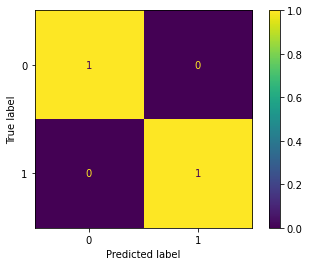

In [119]:
display = ConfusionMatrixDisplay(conf_matrix)
display.plot()

These metrics are too good to be true, Am I overfitting the model?

# 6) Final testing on the model

In [121]:
df_test = strat_test_set.copy()

In [122]:
# Preparing the test set throught the pipeline

df_test = binary_encoding(df_test, attributes=["deposit","housing","loan","default"])

X_test = preprocessing_pipeline.fit_transform(df_test[list(attributes_num)+list(attributes_cat)])

In [123]:
y_test = df_test.deposit.values

In [124]:
X_test.shape, y_test.shape

((2233, 44), (2233,))

Making predictions

In [125]:
y_test_pred = model_decisionT_classifier.predict(X_test)

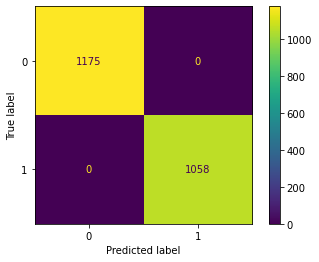

In [126]:
conf_matrix = confusion_matrix(y_test, y_test_pred)
display = ConfusionMatrixDisplay(conf_matrix)
display.plot()

In [128]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1175
           1       1.00      1.00      1.00      1058

    accuracy                           1.00      2233
   macro avg       1.00      1.00      1.00      2233
weighted avg       1.00      1.00      1.00      2233



Umm...not bad at all!!

It turns out that the model is working fine, we made a couple of really good decisions:

- Splitting the orignal dataset before making any kind of EDA in order to avoid **data leakage**.
- Paying special attention to the attributes with strong correlation to the label.
- Analyzing in detail those attributes.
- Choosing the right value for the `max_features` atttibute (this regularized the model).
- Since we had just a few attributes with strong correlation to the label, we create a new one that resulted having the strongest correlation among all, this definitely helped our model to be way more efficient.
- Testing various combinations of hyperparameters through the `GridSearchCV` function.

We are able to predict efficiently if a bank's client will sign up for a *term deposit*, we have accomplish our **business objective**!!